In [79]:
import json
import tarfile
import pprint
from datetime import datetime
import re
import numpy as np
import math
from matplotlib import pyplot as plt
import pickle
import bisect

In [80]:
first_reg =r"\b((\d{1,3}[\s.]+(\d{3}[\s.]+)*\d{3}|\d+)([,]\s?\d{0,2})*)((?= ((\((.+?)\))|(starych)|(-)|(mln)|(tys[.]?))(?= (\bzłote\b|\bzłotych\b|\bzł\b|\bPLN\b)))|(?= (\bzłote\b|\bzł\b|\bzłotych\b|\bPLN\b)))"
second_reg1 = r"(23 kwietnia 1964)"
second_reg2 = r'(art. 445)|(artykuł 445)'
second_reg3 = r'(23 kwietnia 1964\s*)(?= .{0,70}((Kodeks cywilny)|(kodeksu cywilnego))?.{0,70}((art. 445[,.]?)|(artykuł 445[,.]?)))|((445[,.]?)(?= .{0,70}23 kwietnia 1964))'
third_reg = r"\bszkoda\b|\bszkody\b|\bszkody\b|\bszkód\b|\bszkodzie\bszkodom\b|\bszkodę\bszkody\b|\bszkodą\bszkodami\b|\bszkodzie\bszkodach\b|\bszkodo\b|\bszkody\b"

In [81]:
def get_next(tar):
    for tarinfo in tar:
        if tarinfo.isreg():
            yield json.load(tar.extractfile(tarinfo))

In [82]:
def given_date(date):
    z = datetime.strptime(date, '%Y-%m-%d')
    return z.year == 2015

In [83]:
def find_le(a, x):
    i = bisect.bisect_left(a, x)
    if i != len(a):
        return i
    raise ValueError

In [84]:
reg1= re.compile(first_reg, re.IGNORECASE)
reg21= re.compile(second_reg1, re.IGNORECASE)
reg22= re.compile(second_reg2, re.IGNORECASE)
reg23= re.compile(second_reg3, re.IGNORECASE)
reg3= re.compile(third_reg, re.IGNORECASE)

In [85]:
tar = tarfile.open("saos-dump-23.02.2018.tar.gz", "r:gz")
res = []
count = 0
count_1 = 0
for x in get_next(tar):
    for y in range(len(x['items'])):
        flag = True

        try:

            if(given_date(x['items'][y]['judgmentDate'])):
                for r in reg1.findall((x['items'][y]['textContent'])):
                    d = float(r[0].replace("\xa0", "").replace("\n", "").replace("\u2002", "").replace(" ", "").replace(".", "").replace(",","."))
                    for l in range(len(r)):
                        if l == 'mln':
                            d = d*1e6
                            break
                        if l == 'tys' or l == 'tys.':
                            d = d*1e3
                            break
                    res.append(d)
                for r in range(len(x['items'][y]['referencedRegulations'])):
                    if reg21.search(x['items'][y]['referencedRegulations'][r]['journalTitle']) != None:
                        if reg22.search(x['items'][y]['referencedRegulations'][r]['text']) != None:
                            count += 1
                            flag = False
                            break
                if flag and reg23.search(x['items'][y]['textContent']) != None:
                    count +=1
                if reg3.search(x['items'][y]['textContent']) != None:
                    count_1 +=1
        except KeyError:
            pass
        except ValueError as exc:
            pass

res.sort()
tar.close()

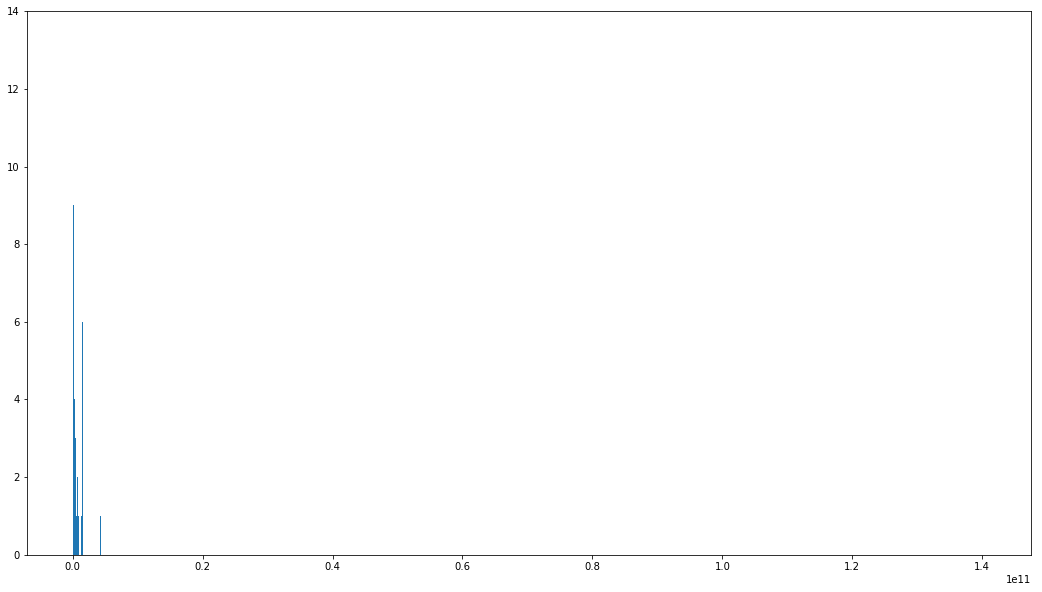

In [86]:
plt.figure(figsize=(18,10))
bins = np.linspace(math.ceil(min(res)),
                   math.floor(max(res)),
                   30000)
plt.ylim(0, 14)
plt.hist(res, bins=bins)
plt.show()

In [87]:
split_i = find_le(res,1e6)
list_a = res[:split_i]
list_b = res[split_i:]

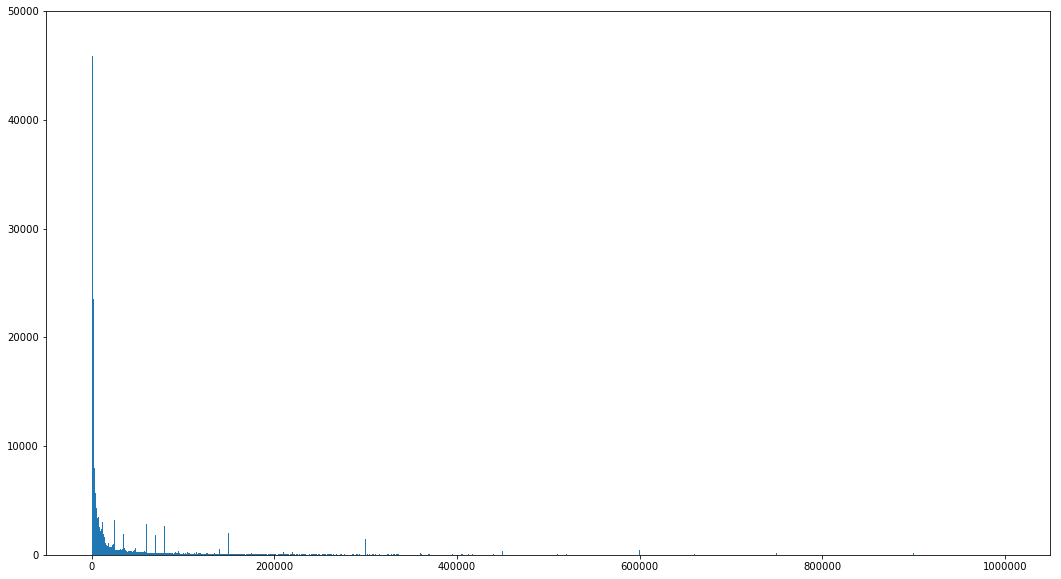

In [88]:
plt.figure(figsize=(18,10))
bins = np.linspace(math.ceil(min(list_a)),
                   math.floor(max(list_a)),
                   3000)
plt.ylim(0, 50000)
plt.hist(list_a, bins=bins)
plt.show()

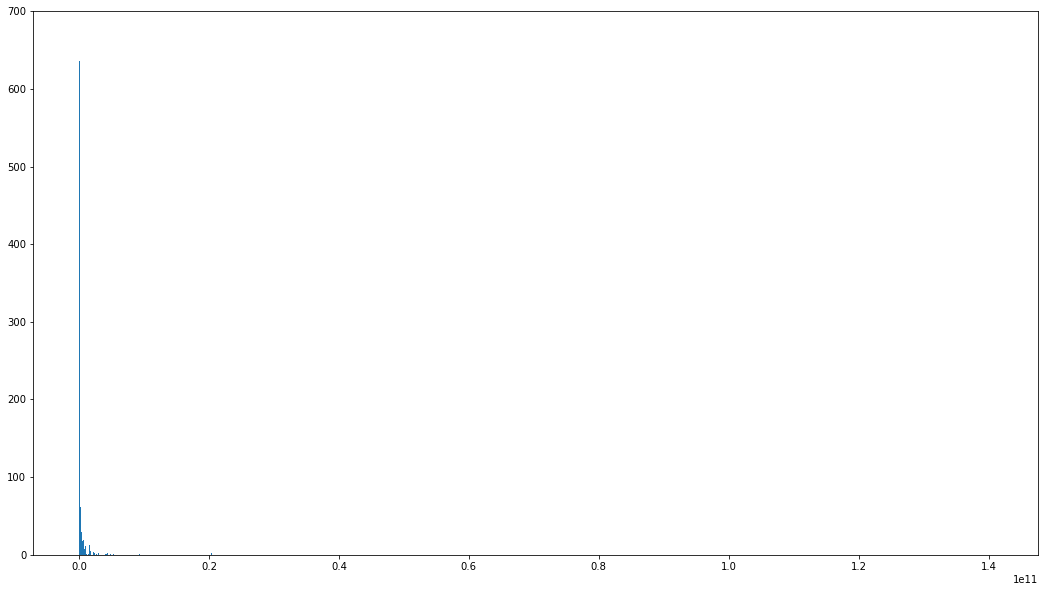

In [89]:
plt.figure(figsize=(18,10))
bins = np.linspace(math.ceil(min(list_b)),
                   math.floor(max(list_b)),
                   3000)
plt.ylim(0, 700)
plt.hist(list_b, bins=bins)
plt.show()

In [90]:
print("Całkowita ilość odwołań do arykułu 445 Kodeksu cywilnego: {0}".format(str(count)))

Całkowita ilość odwołań do arykułu 445 Kodeksu cywilnego: 2542


In [91]:
print("Całkowita liczba orzeczeń zawierających słowo szkoda: {0}".format(str(count_1)))

Całkowita liczba orzeczeń zawierających słowo szkoda: 14768
